In [1]:
import json
import jsondiff
import numpy as np
import matplotlib.pyplot as plt
import smopy
from numpy.random import default_rng
import scipy.stats
from scipy.spatial import distance
import mplleaflet
from geopy import distance as geopy_distance #geodesic accurate, great_circle has an error of 0.5% but 20x faster
from scipy import interpolate
import requests
import polyline
import os

In [102]:
def get_hamburg_center():
    return [53.5488, 9.9872]

def get_hamburg_window():
    center=get_hamburg_center()
    return [[center[0]-0.15,center[1]-0.25],[center[0]+0.15,center[1]+0.25]]

# Update map without opening it (modified from show() from _display.py)
def mplleaflet_update(fig=None, path='_map.html', **kwargs):
    """
    Convert a Matplotlib Figure to a Leaflet map.
    ----------
    fig : figure, default gcf()
        Figure used to convert to map
    path : string, default '_map.html'
        Filename where output html will be saved
    See fig_to_html() for description of keyword args.
    """
    fullpath = os.path.abspath(path)
    with open(fullpath, 'w') as f:
        mplleaflet.save_html(fig, fileobj=f, **kwargs)
        
def extract_json_positions(data):
    '''
    Extract position tuples (latitude, longitude) from critical maps json.
    
    Parameters:
    data : dictonary
        json dictonary from critical maps website with n
        (longitude, latitude) tuples
    Returns:
    positions : numpy 2xn array
    '''
    locations = data['locations']
    positions = np.empty((0,2));
    for ident in locations:
        loc = locations[ident]
        positions=np.append(positions,[[loc['latitude']*1e-6,loc['longitude']*1e-6]],axis=0)
    return positions

def open_cm_log(path):
    ''' Open logged json in path, return json'''
    with open(path,'r') as f:
        data = json.load(f);
    return data
def distance_per_pixel(latitude,zoomlevel):
    ''' Calculate horizontal distance of each pixel for a given zoomlevel at a specific latitude (in degrees) '''
    C = 40075016.686; # Equotrial circumference of the earth
    return C*np.cos(latitude*np.pi/180)/2**(zoomlevel+8)

def get_points_within_window(positions,window=get_hamburg_window()):
    # Window format [[min_long, min_lat],[max_long,max_lat]]
    idx = np.logical_and(np.logical_and(positions[:,0] > window[0][0],positions[:,0] < window[1][0]),\
                         np.logical_and(positions[:,1] > window[0][1],positions[:,1] < window[1][1]))
    return positions[idx]

def get_points_in_circle(positions,center=get_hamburg_center(),radius_km=20):
    ''' Return positions (long, latidude) which are in a circle at center (longitude, latidude) with radius given in km '''
    distances = np.array([geopy_distance.great_circle(p,center).km for p in positions])
    return positions[distances <= radius_km]

    
#name = 'cm_logs/20220624_202509.txt' # works okayis
#name = 'cm_logs/20220624_210255.txt' 
# name = 'cm_logs/20220624_203957.txt' 
#name = 'cm_logs/20220624_204244.txt'
# name = '20220624_202735'
# name = '20220624_202746'

name = '20220624_203453'
#name = '20220624_203134'

data = open_cm_log('cm_logs/' + name + '.txt')
# STEP 1: Rough geographic selection 
position_list = extract_json_positions(data)
#positions_city = get_points_in_circle(position_list)
# More efficient
positions_city = get_points_within_window(position_list)

# Second round
median = np.median(positions_city,axis=0)
p0 = get_points_in_circle(positions_city, median, radius_km=2)

plt.plot(positions_city[:,1],positions_city[:,0],'b.')
plt.plot(median[1],median[0],'xr',ms=20)
plt.plot(p0[:,1],p0[:,0],'ko') #plot longitude, latitude
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [103]:
def filter_train(point_list,debug=0,n_next=5,crit_thr=6):
    # Calculate distance maps, using geopy gedoesic as custom distance function
    # see https://stackoverflow.com/questions/31632190/measuring-geographic-distance-with-scipy
    # VERY costly function because geopy_distance.geodesic is slow
    D = distance.squareform(distance.pdist(point_list, lambda u, v: geopy_distance.great_circle(u,v).m))
    closest = np.argsort(D, axis=1) #each line represents closest point indices
    crit = np.mean(np.sort(D,axis=1)[:,1:n_next],axis=1)
    if debug:
        counts,edges = np.histogram(crit,bins=101)
        plt.stairs(counts,edges,fill=True)
        plt.show()
        plt.figure(figsize=(6,6))
        print('Median:',np.median(crit))
    selec = crit<crit_thr*np.median(crit)
    # Return point list and distance matrix because it is computationally expensive to calculate
    return point_list[selec,:],D[np.ix_(selec,selec)]

# STEP 2: Filter points belonging to train
p1,D1=filter_train(p0,n_next=3,crit_thr=2)

plt.plot(p0[:,1],p0[:,0], 'xr', ms=5, mew=2);
plt.plot(p1[:,1],p1[:,0], 'ob', ms=3, mew=2);
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [99]:
def median_with_nearest(point_list,D,n=3):
    # TODO not correct median!! -> choose point with smallest total distance to both other points would be the equivalent
    # Point list, square distance matrix for points 
    # always use an odd number for n, otherwise mean is calculated!
    closest_selec = np.argsort(D, axis=1) #each line represents closest point indices
    # Do some averaging to get rid of small outliers (e.g. people blocking traffic)
    point_list_median = np.empty_like(point_list)
    point_list_median[:] = np.nan;
    for ii in range(len(point_list)):
        # print(ii,closest_selec[ii,0:n])
        # Pairwise distances for 3 neighboring points:
        D_sub = D[np.ix_(closest_selec[ii,0:n],closest_selec[ii,0:n])]
        # Find geometric median by finding point with smalles quaratic distance
        median_idx_sub = np.argsort(np.sum(np.square(D_sub),axis=0))[0]
        point_median = point_list[closest_selec[ii,median_idx_sub]]
        if point_median not in point_list_median:
            point_list_median[ii,:] = point_median
    # Remove redundant points
    #unique_idx = np.unique(point_list_median,axis=0,return_index=True)[1] # disregard sorted unique output, just indices
    unique_idx = np.logical_not(np.isnan(point_list_median))[:,0]
    point_list_median= point_list_median[unique_idx]
    # We have to recalculate because median values are not the same, D[np.ix_(unique_idx,unique_idx)] is wrong!
    #D=distance.squareform(distance.pdist(point_list_median, lambda u, v: geopy_distance.great_circle(u,v).m))
    return point_list_median,D[np.ix_(unique_idx,unique_idx)]

# STEP 3: Sort out outliers within train by taking median along both axis independently for 3 nearest points
p1_avg,D1_avg = median_with_nearest(p1,D1,n=3)

plt.figure(figsize=(6,6))
plt.plot(p1[:,1],p1[:,0], 'ob', ms=5, mew=2);
plt.plot(p1_avg[:,1],p1_avg[:,0], 'xr', ms=5, mew=2);
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Trivial pathlength: 2231.4147391864003


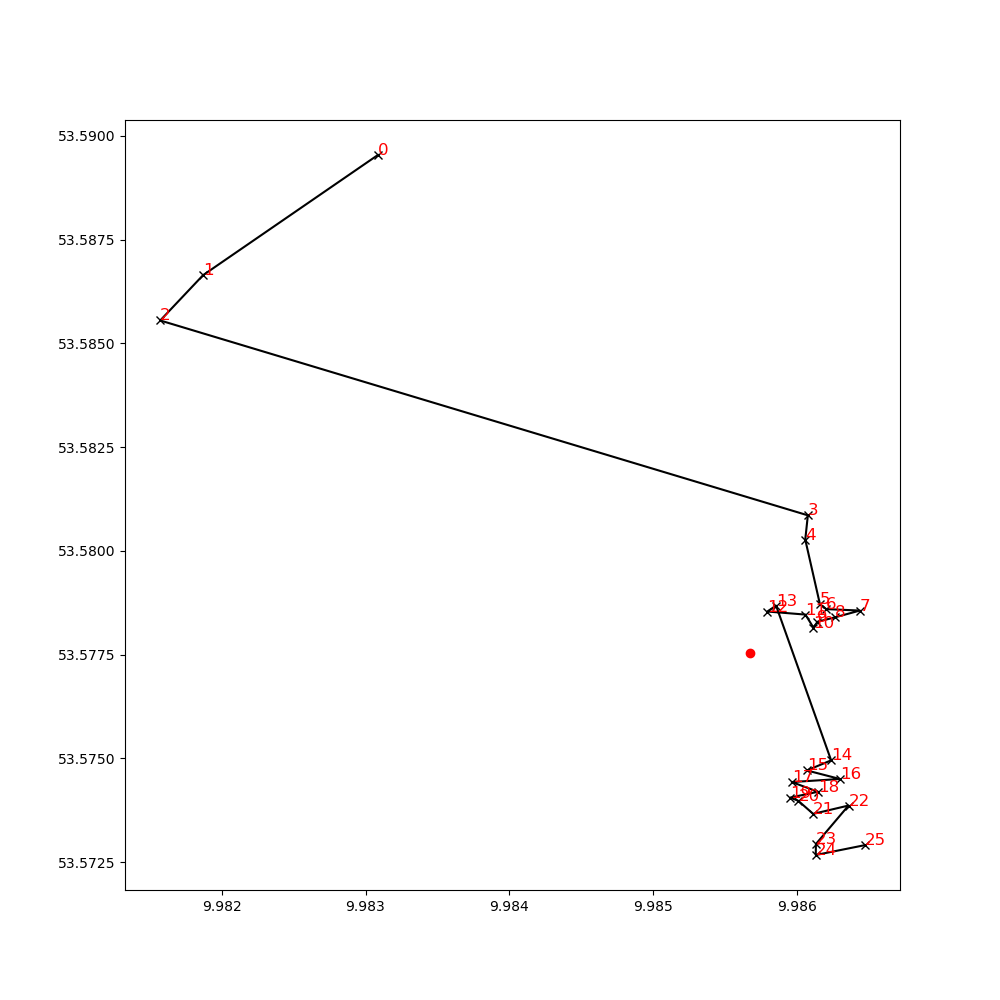

In [100]:
# helper functions
def getPathLength(path):
    return np.sum([geopy_distance.great_circle(u,v).m for u,v in zip(path[:-1],path[1:])])
    
def find_starting_point_idx(points):
    # Find outermost point with the largest distance to the mean of all points
    mean = np.median(points,axis=0)
    #print(mean)
    dist_to_mean = [geopy_distance.great_circle(p,mean).m for p in points]
    return np.argmax(dist_to_mean)
    
def plot_points(points):
    plt.plot(points[:,1],points[:,0],'-xk')
    for ii,point in enumerate(points):
        if ii%2==1 or True:
            plt.text(point[1], point[0], str(ii), color="red", fontsize=12)

def sort_points(point_list,D): 
    closest1_avg = np.argsort(D, axis=1) #each line represents closest point indices
    # Reorder points according to closest points (second column in closest1_avg, first column points to point itself)
    sorted_points_idx = []
    next_point = find_starting_point_idx(point_list)
    for ii in range(0,len(point_list)):
        sorted_points_idx.append(next_point)
        ii_neighbor = 0
        while len(sorted_points_idx) < len(point_list) and next_point in sorted_points_idx:
            next_point = closest1_avg[sorted_points_idx[-1],ii_neighbor] # Check neighbors of last point
            ii_neighbor = ii_neighbor + 1
    sorted_points = point_list[sorted_points_idx,:]
    # Resort also distance array
    sorted_D = np.empty_like(D)
    for ii,x in enumerate(D):
        for jj,y in enumerate(x):
            sorted_D[ii,jj] = D[sorted_points_idx[ii],sorted_points_idx[jj]]
    return sorted_points,sorted_D

# STEP 4: Sort points
#%matplotlib widget
p2,D2 = sort_points(p1_avg,D1_avg)
print('Trivial pathlength:',getPathLength(p2))
plt.figure(figsize=(10,10))
plot_points(p2)
tmp = np.mean(p2,axis=0)
plt.plot(tmp[1],tmp[0],'or')
#mplleaflet.display()

In [30]:
idx1,idx2 = [20,22]
t1 = p1_avg[idx1]
t2 = p1_avg[idx2]
print(t1)
print(t2)
print(D1_avg[idx1,:])
print(geopy_distance.great_circle(t1,t2).m)

[53.596563  9.983905]
[53.595115  9.983757]
[1889.61589674  627.01022964 2380.41713929 1752.4877593  1631.18414532
  806.78723499 1395.99997159 2009.47113967 2048.09354298  220.81846513
  264.74565499  392.23516612 1120.52909573 1845.11937107 2143.29501563
  751.02807973 1553.45371115 1207.34736818 1306.79451101  911.3262682
    0.         1909.72414404  378.19859515  272.11373787  294.6782112
 1023.69766695 1994.56866626 1159.07761086 1471.65267906]
161.30643221681692


In [6]:
# helper functions to remove intersection
#https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/
# A Python3 program to find if 2 given line segments intersect or not
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
# Given three collinear points p, q, r, the function checks if 
# point q lies on line segment 'pr' 
def onSegment(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False
  
def orientation(p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
      
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/ 
    # for details of below formula. 
      
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):
          
        # Clockwise orientation
        return 1
    elif (val < 0):
          
        # Counterclockwise orientation
        return 2
    else:
          
        # Collinear orientation
        return 0
  
# The main function that returns true if 
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1,q1,p2,q2):
      
    # Find the 4 orientations required for 
    # the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
  
    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
  
    # Special Cases
  
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True
  
    # If none of the cases
    return False

def removeLoops(path):
    if len(path)<=3:
        return path
    newPath = [];
    inLoop = False; # Variable to keep track if we are in a loop or not
    #print(path)
    for ii in range(0,len(path)):
        # Add point to path if we are not in a loop
        if not inLoop:
            newPath.append(path[ii,:])
        # Only check lines upstream if we are on the good path (just more efficient)
        if not inLoop:
            jjRange = [ii+2, len(path)-1]
        else:
            jjRange = [0, ii-1]
        for jj in range(jjRange[0],jjRange[1]):
            if ii+1==jj or jj==ii or jj+1==ii or ii+1==len(path):
                continue
            # Edge from ii to ii+1
            p1 = Point(path[ii,0],path[ii,1])
            q1 = Point(path[ii+1,0],path[ii+1,1])
            # Edge from jj + jj+1
            p2 = Point(path[jj,0],path[jj,1])
            q2 = Point(path[jj+1,0],path[jj+1,1])
            
            if doIntersect(p1, q1, p2, q2):
                inLoop = not inLoop;
                print('(',ii,'-',ii+1,') and (',jj,'-',jj+1,") Crossed intersection; inLoop=",inLoop)
    # Add last point if still in loop
    #if inLoop:
    #    print('Still in loop. Add last point.')
    #    newPath.append(path[-1,:])
    return np.array(newPath)

In [7]:
#https://spatialthoughts.com/2020/02/22/snap-to-roads-qgis-and-osrm/
#https://github.com/ustroetz/python-osrm

def osrm_match(point_list,n_split_route=5):
    # Use matching algorithm
    #/match/v1/{profile}/{coordinates}?steps={true|false}&geometries={polyline|polyline6|geojson}&overview={simplified|full|false}&annotations={true|false}
    # coordinates	String of format {longitude},{latitude};{longitude},{latitude}[;{longitude},{latitude} ...] 
    # Add some radiuses in order to allow the for some deviations. Otherwise, routes are planned into adjacent streets.
    # TODO split route
    baseurl = 'http://router.project-osrm.org/match/v1/driving/' + \
        ';'.join(['%.6f' % point[1] + ',' + '%.6f' % point[0] for point in point_list[:,:]]) + '?'\
        'radiuses=' + ';'.join(['15']*len(point_list[:,:])) + \
        '&tidy=true' + \
        '&gaps=ignore'
    r =requests.post(baseurl)
    jp = json.loads(r.text)
    #print(jp)
    if 'matchings' in jp:
        polyline0 = jp['matchings'][0]['geometry']
    else:
        print('No matching')
        return None
    match0 = np.array(polyline.decode(polyline0, 5))
    # Remove any redundant points in route as this will not work for the loop detection
    unique_idx = np.unique(match0,axis=0,return_index=True)[1] # disregard sorted unique output, just indices
    match0Unique = np.array([match0[index] for index in sorted(unique_idx)])
    match0NoLoop = removeLoops(match0Unique)
    return match0NoLoop, match0Unique

# STEP 5: Snap points to road
match0NoLoop,match0Unique = osrm_match(p2[:,:])

f=plt.figure(figsize=(6,6))
plt.plot(p2[:,1],p2[:,0], 'ok')
plt.plot(p0[:,1],p0[:,0], 'xk')
print('With loops:',getPathLength(match0Unique))
print('Loops removed:',getPathLength(match0NoLoop))
plt.plot(match0Unique[:,1],match0Unique[:,0],'b-')
plt.plot(match0NoLoop[:,1],match0NoLoop[:,0],'r-',linewidth=3)
mplleaflet.display(fig=f)
#mplleaflet.show()
#mplleaflet_update()
#https://www.google.de/maps/dir/53.596937,++9.983905/53.581667,++9.985883/@53.591682,9.9808703,14z/data=!3m1!4b1!4m10!4m9!1m3!2m2!1d9.983905!2d53.596937!1m3!2m2!1d9.985883!2d53.581667!3e2

( 6 - 7 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 11 - 12 ) Crossed intersection; inLoop= False
( 7 - 8 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 10 - 11 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 25 - 26 ) and ( 30 - 31 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 25 - 26 ) Crossed intersection; inLoop= False
With loops: 3061.221634761647
Loops removed: 2295.4385978043024


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
